In [1]:
import os
import json
import string
import warnings
import pandas as pd
import seaborn as sns

warnings.filterwarnings(action='ignore', message='numpy.dtype size changed')
warnings.filterwarnings(action='ignore', message='compiletime version 3.5 of module')

if not 'workbookDir' in globals():
    workbookDir = os.getcwd()
os.chdir(os.path.split(workbookDir)[0])


%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from synthesized.testing.evaluation import Evaluation
from synthesized.testing import synthetic_distributions as syn_dist
branch = os.environ.get('EVALUATION_BRANCH', 'n/a')
revision = os.environ.get('EVALUATION_REVISION', 'n/a')
group = "synthetic"
config_path = os.environ.get('EVALUATION_CONFIG_PATH', "configs/evaluation/synthetic_distributions.json") 
with open(config_path, 'r') as f:
    configs = json.load(f)
    config = configs["instances"]["synthetic"]
evaluation = Evaluation(branch=branch, revision=revision, group=group) # use this line if you want to run this notbook manually
# evaluation = Evaluation()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Copyright (C) Synthesized Ltd. - All Rights Reserved
License key: EE6B-6720-67A2-32F3-3139-2D31-322D-B531
Expires at: 2019-12-31 00:00:00


In [3]:
from synthesized.testing import UtilityTesting

In [4]:
from synthesized import HighDimSynthesizer

In [5]:
import numpy as np

In [6]:
def plot_data(data, ax=None):
    if data.shape[1] == 1:
        if data['x'].dtype.kind == 'O':
            return sns.countplot(data["x"], ax=ax)
        else:
            return sns.distplot(data["x"], ax=ax)
    if data.shape[1] == 2:
        if data['x'].dtype.kind == 'O' and data['y'].dtype.kind == 'f':
            order = sorted(data["x"].unique().tolist())
            sns.violinplot(x="x", y="y", data=data, ax=ax)
        elif data['x'].dtype.kind == 'f' and data['y'].dtype.kind == 'f':
            #return sns.jointplot(x="x", y="y", data=data, kind="kde", ax=ax)
            return ax.hist2d(data['x'], data['y'], bins=100)
        elif data['x'].dtype.kind == 'O' and data['y'].dtype.kind == 'O':
            crosstab = pd.crosstab(data['x'], columns=[data['y']]).apply(lambda r: r/r.sum(), axis=1)
            sns.heatmap(crosstab, vmin=0.0, vmax=1.0, ax=ax)
        else:
            return sns.distplot(data, ax=ax)
    else:
        return sns.distplot(data, ax=ax)

###  Evaluation metrics

In [7]:
def max_correlation_distance(orig, synth):
    return np.abs((orig.corr() - synth.corr()).to_numpy()).max()

def mean_ks_distance(orig, synth):
    distances = [ks_2samp(orig[col], synth[col])[0] for col in orig.columns]
    return np.mean(distances)

In [8]:
import time
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt



default_metrics = {"avg_distance": mean_ks_distance}

def synthesize_and_plot(data, name, n_iter=config['num_iterations'], metrics=None, 
                        show_anova=False, show_cat_rsquared=False):
    evaluation.record_config(evaluation=name, config=config)
    start = time.time()
    with HighDimSynthesizer(df=data, **config['params']) as synthesizer:
        synthesizer.learn(df_train=data, num_iterations=n_iter)
        synthesized = synthesizer.synthesize(num_rows=len(data))
        print('took', time.time() - start, 's')
        print("Metrics:")
        for key, metric in metrics.items():
            value = metric(orig=data, synth=synthesized)
            evaluation.record_metric(evaluation=name, key=key, value=value)
            print(f"{key}: {value}")
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
        ax1.set_title('orig')
        ax2.set_title('synth')
        plot_data(data, ax=ax1)
        plot_data(synthesized, ax=ax2)
        if show_anova:
            testing = UtilityTesting(synthesizer, data, data, synthesized)
            testing.show_anova()
        if show_cat_rsquared:
            testing = UtilityTesting(synthesizer, data, data, synthesized)
            testing.show_categorical_rsquared()

### Gauss "ball" outside of center

In [ ]:
data = syn_dist.create_gauss_ball(x_mean=1000, x_std=100, y_mean=100, y_std=10, size=10000)

In [ ]:
synthesize_and_plot(data, 'ball', metrics=default_metrics)

### Gauss "ball" around of zero

In [ ]:
data = syn_dist.create_gauss_ball(x_mean=0, x_std=100, y_mean=0, y_std=10, size=10000)

In [ ]:
synthesize_and_plot(data, 'ball_ext', metrics=default_metrics)

### Correlated Gaussian far from zero

In [ ]:
data = syn_dist.create_gauss_ball(x_mean=1000, x_std=100, y_mean=100, y_std=10, size=10000, cor=0.8)

In [ ]:
metrics = dict(default_metrics)
metrics["max_correlation_distance"] = max_correlation_distance
synthesize_and_plot(data, 'corr_ball_far', metrics=metrics)

### Correlated Gaussian around zero

In [ ]:
data = syn_dist.create_gauss_ball(x_mean=0, x_std=100, y_mean=0, y_std=10, size=10000, cor=0.8)

In [ ]:
metrics = dict(default_metrics)
metrics["max_correlation_distance"] = max_correlation_distance
synthesize_and_plot(data, 'corr_ball_zero', metrics=metrics)

### Line of noise that far from zero

In [ ]:
data = syn_dist.create_line(x_range=(0, 1000), intercept=100, slope=-0.1, y_std=10, size=10000)

In [ ]:
synthesize_and_plot(data, 'line', metrics=default_metrics)

### Line of noise that comes from zero

In [ ]:
data = syn_dist.create_line(x_range=(0, 1000), intercept=0, slope=0.1, y_std=10, size=10000)

In [ ]:
synthesize_and_plot(data, 'line_ext', metrics=default_metrics)

### Power law distribution

In [ ]:
data = syn_dist.create_power_law_distribution(shape=0.5, scale=1000, size=10000)

In [ ]:
synthesize_and_plot(data, 'power_law', metrics=default_metrics)

### Conditional distribution

In [ ]:
data = syn_dist.create_conditional_distribution((10,2), (20, 5), (30, 1), size=10000)

In [ ]:
synthesize_and_plot(data, 'conditional', metrics=default_metrics)

### Bernoulli distribution

In [ ]:
data = syn_dist.create_bernoulli(probability=0.5, size=10000)

In [ ]:
synthesize_and_plot(data, 'bernoulli_50/50', metrics=default_metrics)

In [ ]:
data = syn_dist.create_bernoulli(probability=0.2, size=10000)

In [ ]:
synthesize_and_plot(data, 'bernoulli_20/80', metrics=default_metrics)

### Categorical distribution

In [9]:
data = syn_dist.create_uniform_categorical(n_classes=100, size=100000)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
took 42.28576421737671 s
Metrics:
avg_distance: 0.013889999999999958


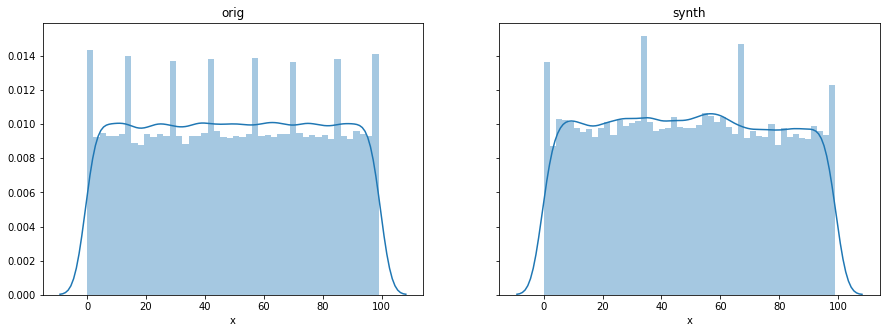

In [10]:
synthesize_and_plot(data, 'categorical_uniform', metrics=default_metrics, n_iter=10000)

In [11]:
data = syn_dist.create_power_law_categorical(n_classes=10, size=10000)

took 8.266245126724243 s
Metrics:
avg_distance: 0.044399999999999995


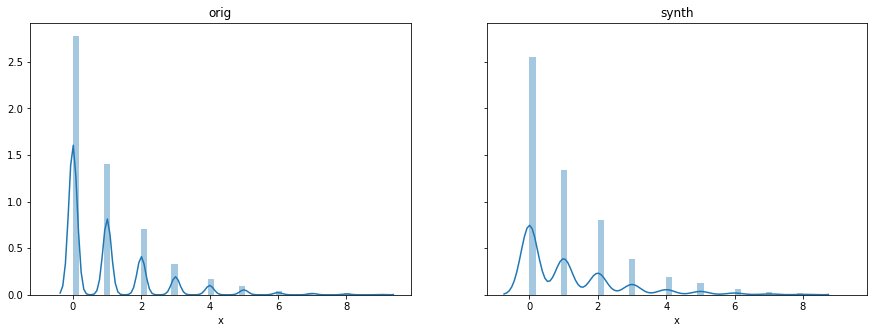

In [12]:
synthesize_and_plot(data, 'categorical_powerlaw', metrics=default_metrics)

In [13]:
data = syn_dist.create_mixed_continuous_categorical(n_classes=10, size=10000)

took 8.123363018035889 s
Metrics:
avg_distance: 0.0406


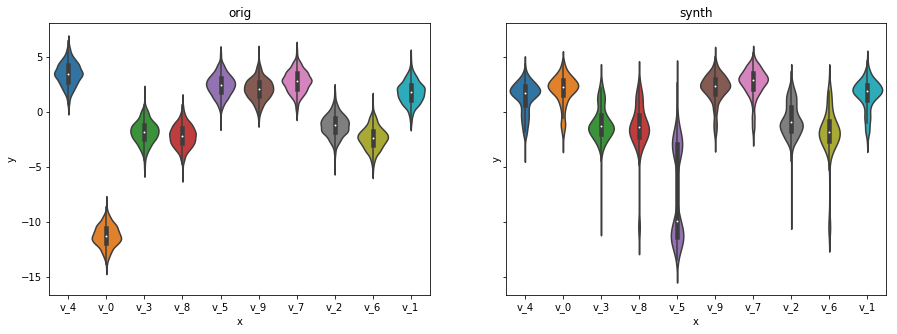

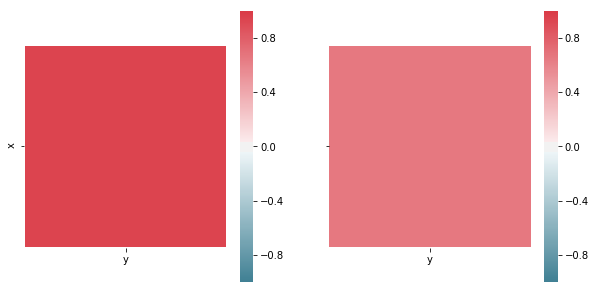

In [14]:
synthesize_and_plot(data, 'mixed_categorical_continuous', metrics=default_metrics, show_anova=True)

In [ ]:
evaluation.write_metrics()